# **Google Colab: VGG16 (pretrained) and ResNet18 (pretrained)**

**Setup & imports**

In [ ]:
# Install dependencies (optional if Colab has them)
!pip install torch torchvision torchsummary

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchsummary import summary

**Check device (GPU or CPU)**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


**Data preprocessing & augmentation**

In [ ]:
# Data augmentation (for training)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Only normalization (for testing)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = trainset.classes
print("Classes:", classes)

100%|██████████| 170M/170M [00:03<00:00, 44.4MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


**Visualize some training images**

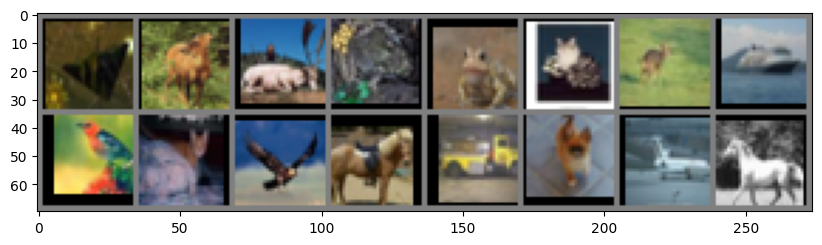

Labels: airplane deer deer frog frog cat deer ship bird cat bird horse truck dog airplane horse


In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:16]))
print('Labels:', ' '.join(f'{classes[labels[j]]}' for j in range(16)))

**Define VGG16 model**

In [ ]:
import torchvision.models as models

# Load pretrained VGG16
vgg16 = models.vgg16(pretrained=True)

# Modify classifier for CIFAR-10 (10 classes instead of 1000)
vgg16.classifier[6] = nn.Linear(4096, 10)

vgg16 = vgg16.to(device)

# Model summary
summary(vgg16, (3, 32, 32))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 195MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

**Define ResNet18 model**

In [ ]:
resnet18 = models.resnet18(pretrained=True)

# Modify final FC layer
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 10)

resnet18 = resnet18.to(device)

# Model summary
summary(resnet18, (3, 32, 32))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 82.6MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

**Training utilities**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    train_acc, test_acc = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        acc = 100. * correct / total
        train_acc.append(acc)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}, Train Acc: {acc:.2f}%")

        # Scheduler step
        scheduler.step()

        # Evaluate on test set
        test_acc.append(evaluate_model(model))

    return train_acc, test_acc

def evaluate_model(model):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc

**Train & evaluate VGG16**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_vgg = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler_vgg = optim.lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)

train_acc_vgg, test_acc_vgg = train_model(vgg16, criterion, optimizer_vgg, scheduler_vgg, num_epochs=10)

Epoch [1/10], Loss: 0.9799, Train Acc: 65.39%
Test Accuracy: 78.45%
Epoch [2/10], Loss: 0.6179, Train Acc: 78.60%
Test Accuracy: 80.55%
Epoch [3/10], Loss: 0.5174, Train Acc: 82.26%
Test Accuracy: 83.01%
Epoch [4/10], Loss: 0.4630, Train Acc: 84.08%
Test Accuracy: 84.68%
Epoch [5/10], Loss: 0.4228, Train Acc: 85.34%
Test Accuracy: 85.72%
Epoch [6/10], Loss: 0.3923, Train Acc: 86.57%
Test Accuracy: 85.50%
Epoch [7/10], Loss: 0.3621, Train Acc: 87.57%
Test Accuracy: 87.23%
Epoch [8/10], Loss: 0.3190, Train Acc: 89.02%
Test Accuracy: 87.19%
Epoch [9/10], Loss: 0.3103, Train Acc: 89.38%
Test Accuracy: 87.44%
Epoch [10/10], Loss: 0.3025, Train Acc: 89.41%
Test Accuracy: 87.32%


**Train & evaluate ResNet18**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_res = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler_res = optim.lr_scheduler.StepLR(optimizer_res, step_size=7, gamma=0.1)

train_acc_res, test_acc_res = train_model(resnet18, criterion, optimizer_res, scheduler_res, num_epochs=10)

Epoch [1/10], Loss: 1.3139, Train Acc: 53.67%
Test Accuracy: 66.77%
Epoch [2/10], Loss: 0.9035, Train Acc: 68.50%
Test Accuracy: 72.37%
Epoch [3/10], Loss: 0.7748, Train Acc: 72.88%
Test Accuracy: 75.52%
Epoch [4/10], Loss: 0.7000, Train Acc: 75.54%
Test Accuracy: 77.09%
Epoch [5/10], Loss: 0.6433, Train Acc: 77.61%
Test Accuracy: 77.75%
Epoch [6/10], Loss: 0.5997, Train Acc: 79.07%
Test Accuracy: 79.07%
Epoch [7/10], Loss: 0.5648, Train Acc: 80.31%
Test Accuracy: 79.88%
Epoch [8/10], Loss: 0.5298, Train Acc: 81.44%
Test Accuracy: 80.60%
Epoch [9/10], Loss: 0.5094, Train Acc: 82.09%
Test Accuracy: 80.38%
Epoch [10/10], Loss: 0.5071, Train Acc: 82.13%
Test Accuracy: 80.77%


**Plot training vs test accuracy**

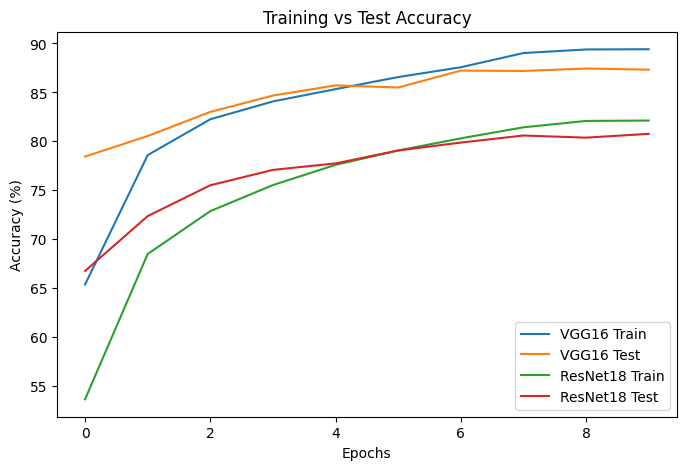

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train_acc_vgg, label="VGG16 Train")
plt.plot(test_acc_vgg, label="VGG16 Test")
plt.plot(train_acc_res, label="ResNet18 Train")
plt.plot(test_acc_res, label="ResNet18 Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Test Accuracy")
plt.legend()
plt.show()

**Confusion Matrix (for best model)**

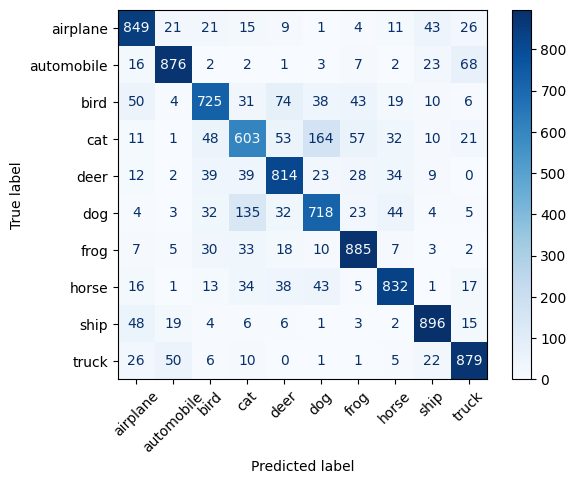

In [ ]:
def plot_confusion_matrix(model):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.show()

# Example: Confusion matrix for ResNet18
plot_confusion_matrix(resnet18)